In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
import time
from statistics import mode
import cv2
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
import os
from keras.layers import Dense,Flatten,GlobalAveragePooling2D,Input,Conv2D,MaxPooling2D,Dropout
from keras.models import Model,load_model,Sequential
from keras.applications.xception import  Xception
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import  ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.mobilenet import MobileNet
import keras.callbacks as kcallbacks
import keras
from keras.preprocessing.image import load_img,img_to_array
import math
import random
from keras.utils import plot_model
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

In [2]:
import pathlib
ds = "./trafic-dataset"
data_dir = pathlib.Path(ds).with_suffix('')

In [3]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

856


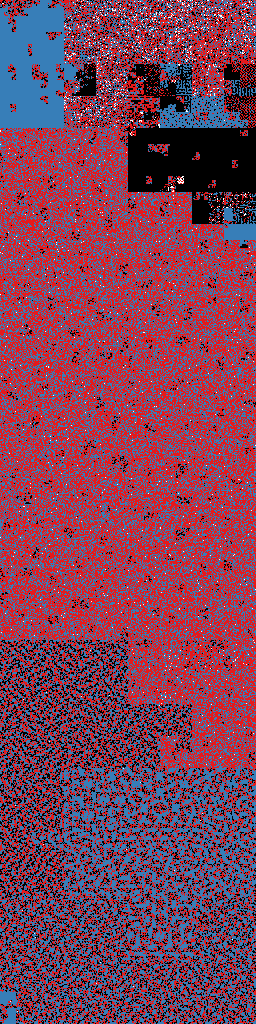

In [4]:
malware = list(data_dir.glob('Malware/*'))
PIL.Image.open(str(malware[0]))

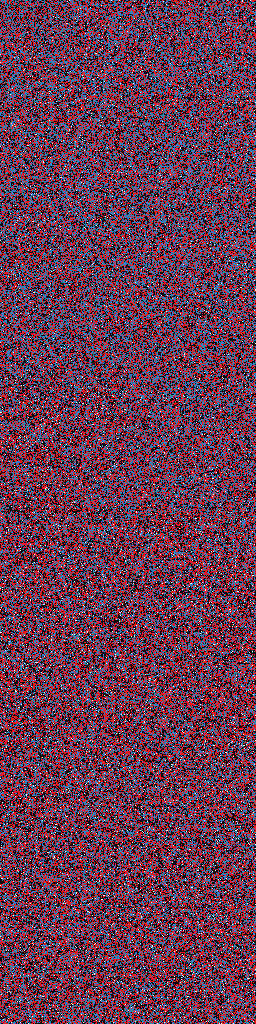

In [5]:
normal = list(data_dir.glob('Normal/*'))
PIL.Image.open(str(normal[1]))

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 856 files belonging to 2 classes.


In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 856 files belonging to 2 classes.
Using 771 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 856 files belonging to 2 classes.
Using 85 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['Malware', 'Normal']


# Visualize the data

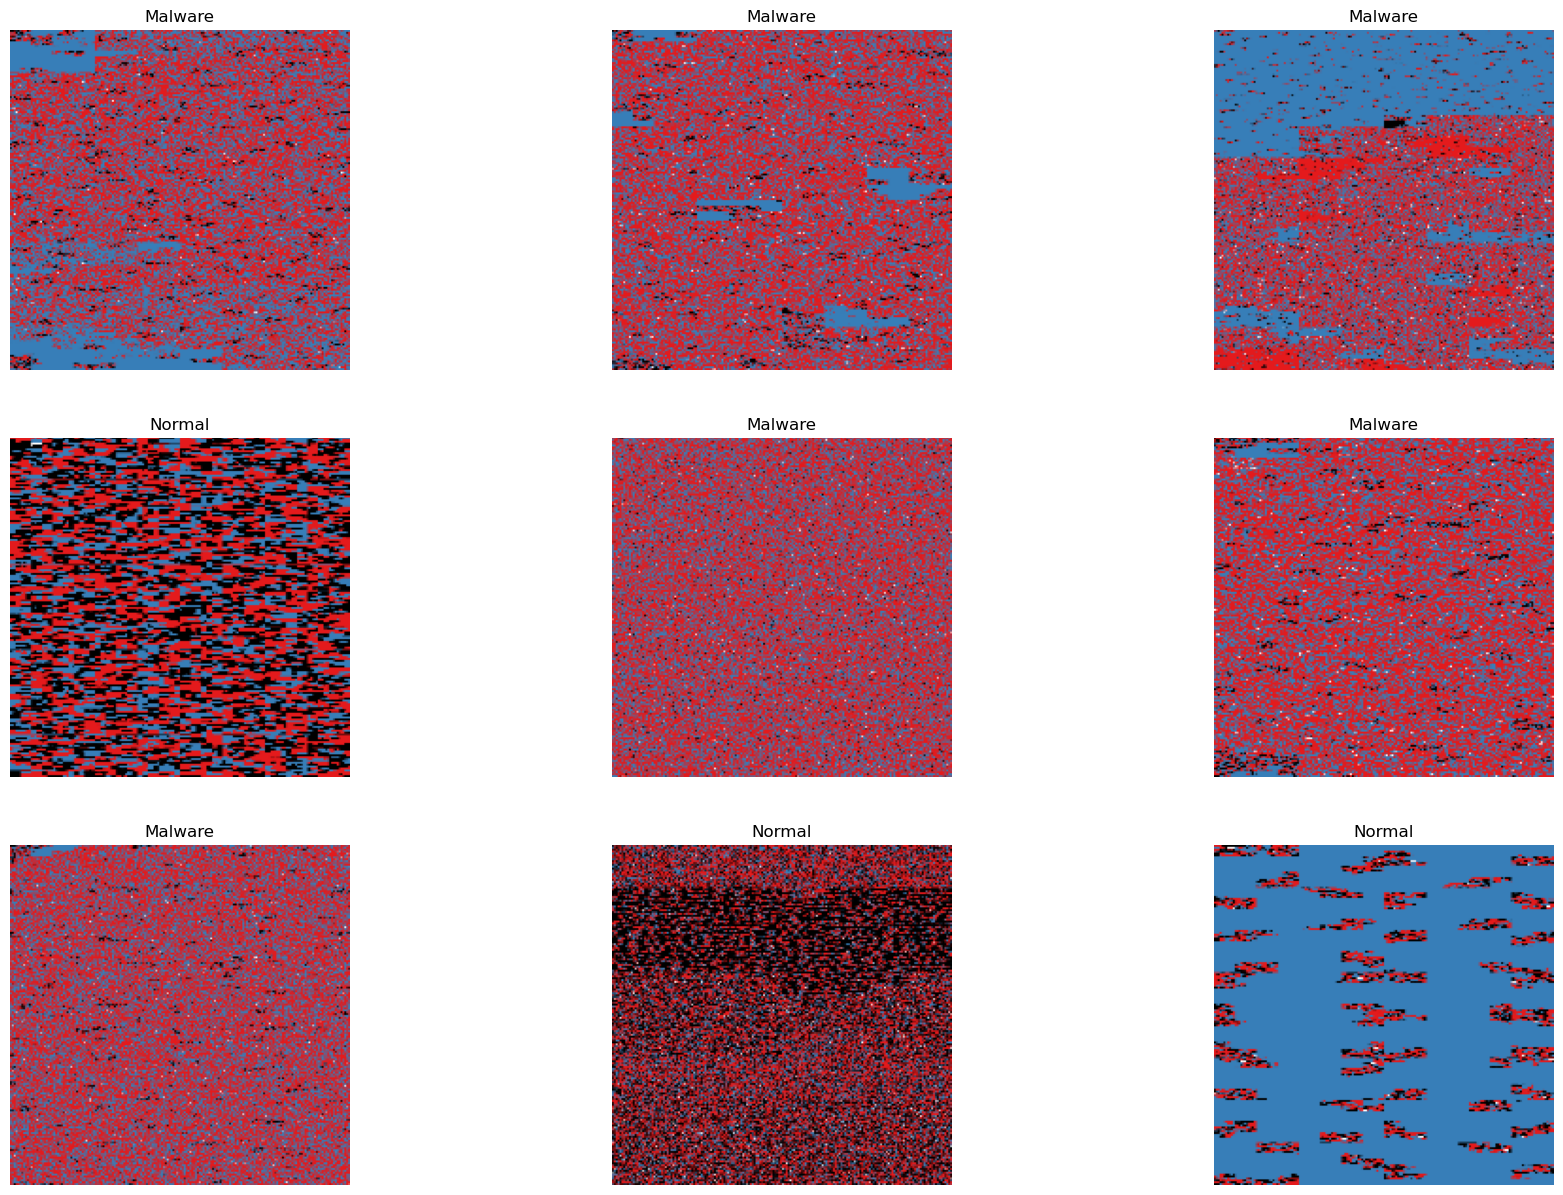

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(22, 15))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


# Chuẩn hóa dữ liệu bằng cách giảm các giá trị đầu vào

In [13]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [16]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Tạo mô hình

In [18]:
# #Train a model
# num_classes = 2

num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

c:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
print(num_classes)

2


# Biên dịch mô hình
# độ chính xác của quá trình đào tạo và xác thực cho tập dữ liệu đào tạo model.compile

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,988,898 (15.22 MB)

 Trainable params: 3,988,898 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 364ms/step - accuracy: 0.6333 - loss: 0.9152 - val_accuracy: 0.6235 - val_loss: 0.7528
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 351ms/step - accuracy: 0.8341 - loss: 0.4436 - val_accuracy: 0.8471 - val_loss: 0.5263
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 325ms/step - accuracy: 0.8471 - loss: 0.3570 - val_accuracy: 0.8588 - val_loss: 0.4805
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 246ms/step - accuracy: 0.8725 - loss: 0.3080 - val_accuracy: 0.8588 - val_loss: 0.4198
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 241ms/step - accuracy: 0.8865 - loss: 0.2714 - val_accuracy: 0.8588 - val_loss: 0.4613
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 227ms/step - accuracy: 0.8869 - loss: 0.2511 - val_accuracy: 0.8706 - val_loss: 0.4432
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 226ms/step - accuracy: 0.8958 - loss: 0.2673 - val_accuracy: 0.8706 - val_loss: 0.4684
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 224ms/step - accuracy: 0.9070 - loss: 0.2008 - val_accuracy: 0.8824 - val

# Tạo các biểu đồ về mất mát dữ liệu và độ chính xác trên tập train và validation

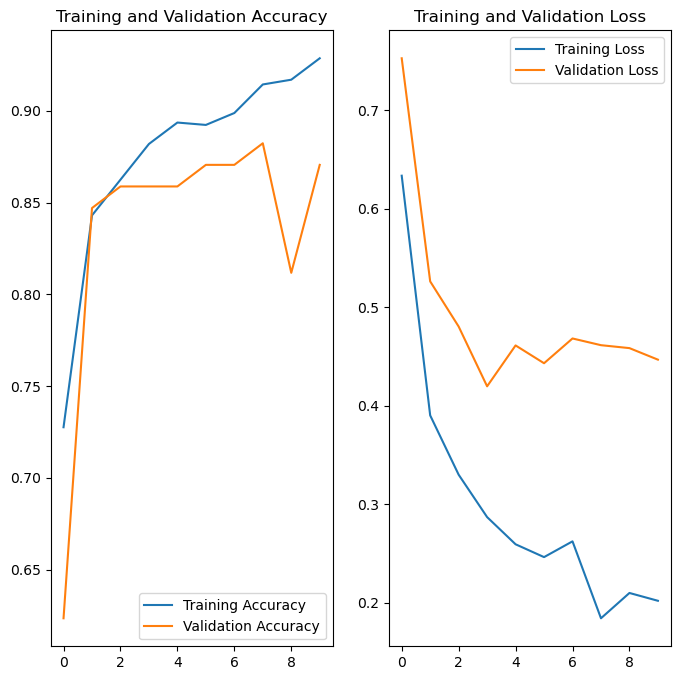

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Các biểu đồ cho thấy rằng độ chính xác của quá trình huấn luyện và độ chính xác của việc xác nhận bị ảnh hưởng bởi biên lớn và mô hình chỉ đạt được độ chính xác khoảng 60% trên bộ xác thực.

In [24]:
# Tăng dữ liệu
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

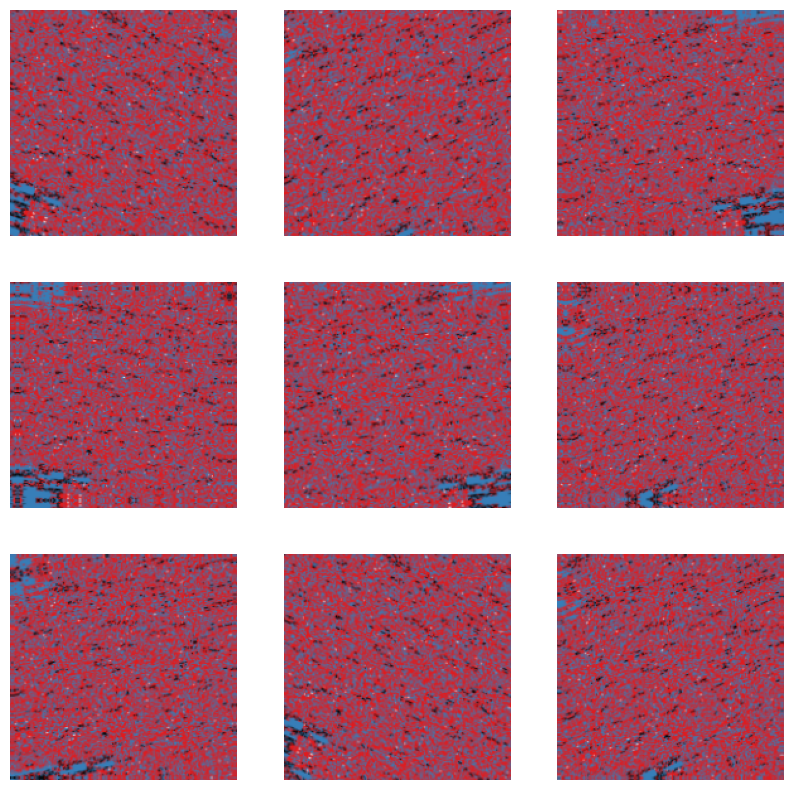

In [25]:
# áp dụng tăng dữ liệu cho cùng một hình ảnh nhiều lần
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Rơi ra ngoài đây là một kĩ thuật giảm việc trang bị quá nhiều (overtooling) về dropout cho mạng lưới
#  Tạo một mạng nơ-ron mới với tf.keras.layers.Dropout trước khi đào tạo nó bằng cách sử dụng các hình ảnh tăng cường

In [26]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [27]:
# Biên dịch và đào tạo mô hình
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
# model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [29]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 304ms/step - accuracy: 0.7010 - loss: 0.5760 - val_accuracy: 0.3529 - val_loss: 4.0031
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 294ms/step - accuracy: 0.8446 - loss: 0.3981 - val_accuracy: 0.3529 - val_loss: 4.1799
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 287ms/step - accuracy: 0.8436 - loss: 0.3706 - val_accuracy: 0.3529 - val_loss: 5.4215
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 280ms/step - accuracy: 0.8550 - loss: 0.3633 - val_accuracy: 0.3529 - val_loss: 4.9450
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 301ms/step - accuracy: 0.8532 - loss: 0.3586 - val_accuracy: 0.3529 - val_loss: 4.8764
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 279ms/step - accuracy: 0.8624 - loss: 0.3688 - val_accuracy: 0.3529 - val_loss: 2.6191
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 286ms/step - accuracy: 0.8595 - loss: 0.3373 - val_accuracy: 0.3529 - val_loss: 6.6695
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 297ms/step - accuracy: 0.8718 - loss: 0.3473 - val_accuracy: 0

# Sau khi áp dụng nâng cấp dữ liệu và tf.keras.layers.Dropout , ít bị overfitting hơn trước và độ chính xác của quá trình đào tạo và xác thực được liên kết chặt chẽ hơn:

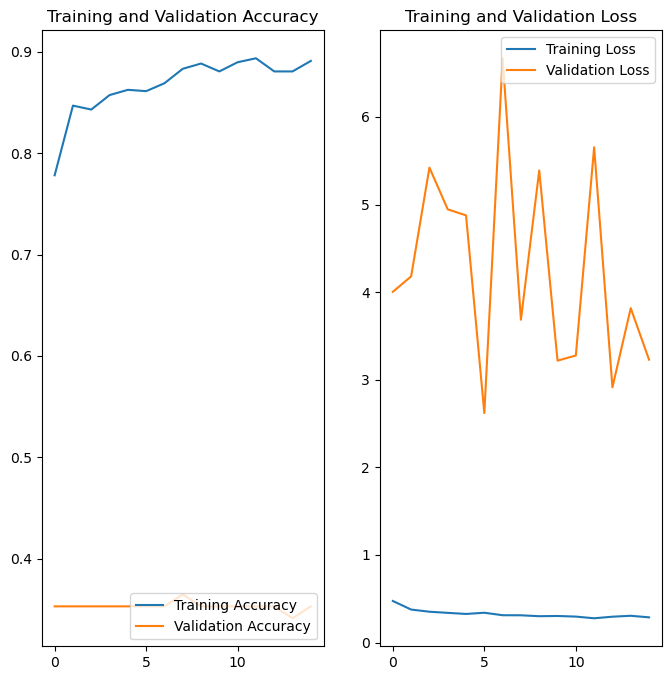

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

3/3 - 0s - 71ms/step - accuracy: 0.3529 - loss: 3.2291


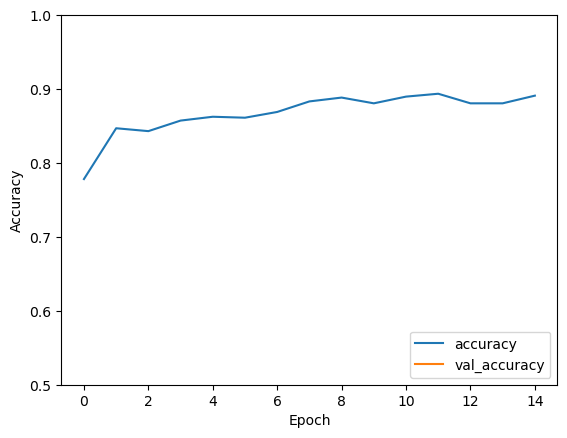

In [31]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(val_ds, verbose=2)

In [32]:
print(test_acc)

0.3529411852359772


# Split folder to train and test

In [33]:
import shutil
import random

# Set the root folder containing the data
root_folder = 'trafic-dataset'

# Define the paths for the train, test, and validation folders
train_path = os.path.join(root_folder, 'train')

val_path = os.path.join(root_folder, 'val')

for path in [train_path, val_path]:
    if not os.path.exists(path):
        os.makedirs(path)

# Set the ratio for train, validation, and test data
train_ratio = 0.9  # 90% for training
val_ratio = 0.1    # 10% for validation


# Iterate through the root folder and move images to train, validation, and test folders
for class_folder in os.listdir(root_folder):
    class_path = os.path.join(root_folder, class_folder)
    if os.path.isdir(class_path):  # Check if it's a directory
        files = os.listdir(class_path)
        random.shuffle(files)  # Shuffle the files to ensure randomness
        train_count = int(len(files) * train_ratio)
        val_count = int(len(files) * val_ratio)

        # Move files to train folder
        for file in files[:train_count]:
            src = os.path.join(class_path, file)
            if os.path.isfile(src):  # Check if the file exists
                dst = os.path.join(train_path, class_folder, file)
                os.makedirs(os.path.dirname(dst), exist_ok=True)  # Create destination directory if it doesn't exist
                shutil.copy(src, dst)

        # Move files to validation folder
        for file in files[train_count:train_count+val_count]:
            src = os.path.join(class_path, file)
            if os.path.isfile(src):  # Check if the file exists
                dst = os.path.join(val_path, class_folder, file)
                os.makedirs(os.path.dirname(dst), exist_ok=True)  # Create destination directory if it doesn't exist
                shutil.copy(src, dst)

        # # Move the rest of the files to the test folder
        # for file in files[train_count+val_count:]:
        #     src = os.path.join(class_path, file)
        #     if os.path.isfile(src):  # Check if the file exists
        #         dst = os.path.join(test_path, class_folder, file)
        #         os.makedirs(os.path.dirname(dst), exist_ok=True)  # Create destination directory if it doesn't exist
        #         shutil.copy(src, dst)

In [34]:
#generate training and test images
TARGET_SIZE=(224,224)
INPUT_SIZE=(224,224,3)
BATCH_SIZE=128	#could try 128 or 32

#Normalization
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        val_path,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 770 images belonging to 2 classes.
Found 84 images belonging to 2 classes.


# Define the image plotting functions

In [77]:
#plot the figures
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # acc
            plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
            # loss
            plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

In [78]:
history_this= LossHistory()

# Construct CNN models
# Model 1: a CNN model by own (baseline)


Một số mô hình được đào tạo trước dựa trên kiến trúc mạng thần kinh tích chập (CNN) đã được phát triển để giải quyết vấn đề này, chẳng hạn như VGG-16, VGG-19, DenseNet và perceptron đa lớp (MLP). Những mô hình được đào tạo trước này có thể được tinh chỉnh và sử dụng làm công cụ trích xuất đặc trưng 

In [79]:
def cnn_by_own(input_shape,num_class,epochs,savepath='./model_weight.keras'):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), strides=(1, 1), input_shape=input_shape, padding='same', activation='relu', kernel_initializer='glorot_uniform'))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='glorot_uniform'))
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='glorot_uniform'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(num_class,activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    #train model
    earlyStopping = kcallbacks.EarlyStopping(monitor='val_acc', patience=2, verbose=1, mode='max')
    saveBestModel = kcallbacks.ModelCheckpoint(filepath=savepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    hist=model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=[earlyStopping,saveBestModel,history_this],
    )

In [88]:
cnn_by_own(input_shape=INPUT_SIZE,num_class=2,epochs=20)
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

1/7 ━━━━━━━━━━━━━━━━━━━━ 36s 6s/step - accuracy: 0.0000e+00 - loss: 0.7212

ResourceExhaustedError: Graph execution error:

Detected at node gradient_tape/sequential_8_1/global_average_pooling2d_25_1/BroadcastTo defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\ADMIN\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "c:\Users\ADMIN\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "c:\Users\ADMIN\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start

  File "c:\Users\ADMIN\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "c:\Users\ADMIN\anaconda3\Lib\asyncio\windows_events.py", line 321, in run_forever

  File "c:\Users\ADMIN\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "c:\Users\ADMIN\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "c:\Users\ADMIN\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "c:\Users\ADMIN\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue

  File "c:\Users\ADMIN\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one

  File "c:\Users\ADMIN\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell

  File "c:\Users\ADMIN\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request

  File "c:\Users\ADMIN\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute

  File "c:\Users\ADMIN\anaconda3\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\ADMIN\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3051, in run_cell

  File "c:\Users\ADMIN\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3106, in _run_cell

  File "c:\Users\ADMIN\anaconda3\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\Users\ADMIN\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3311, in run_cell_async

  File "c:\Users\ADMIN\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3493, in run_ast_nodes

  File "c:\Users\ADMIN\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code

  File "C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16424\2892065341.py", line 1, in <module>

  File "C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16424\2403166459.py", line 16, in cnn_by_own

  File "c:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 118, in error_handler

  File "c:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 323, in fit

  File "c:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 117, in one_step_on_iterator

  File "c:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 105, in one_step_on_data

  File "c:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 69, in train_step

OOM when allocating tensor with shape[128,112,112,128] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu
	 [[{{node gradient_tape/sequential_8_1/global_average_pooling2d_25_1/BroadcastTo}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_126729]

# Model 2: Xception

In [43]:
import keras
# from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout

In [85]:
def xception(num_class, epochs, savepath='./xception.h5.keras', input_shape=INPUT_SIZE):
    model_fine_tune = Xception(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:131]:
        layer.trainable = False
    for layer in model_fine_tune.layers[131:]:
        layer.trainable = True
    x = GlobalAveragePooling2D()(model_fine_tune.output)
    x = Dense(units=256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_class, activation='softmax')(x)
    model = Model(model_fine_tune.input, predictions, name='xception')
    opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    early_stopping = kcallbacks.EarlyStopping(
        monitor='val_acc', patience=3, verbose=1, mode='max')
    save_best_model = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_acc',
        verbose=1,
        save_best_only=True,
        mode='max')
    hist = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[early_stopping, save_best_model, history],
    )
    return hist

7/7 ━━━━━━━━━━━━━━━━━━━━ 66s 9s/step - accuracy: 0.9040 - loss: 0.2236 - val_accuracy: 0.9167 - val_loss: 0.2307
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 17/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 65s 9s/step - accuracy: 0.8922 - loss: 0.2542 - val_accuracy: 0.9048 - val_loss: 0.2420
Epoch 18/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 19/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 63s 9s/step - accuracy: 0.9098 - loss: 0.2187 - val_accuracy: 0.9048 - val_loss: 0.2315
Epoch 20/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


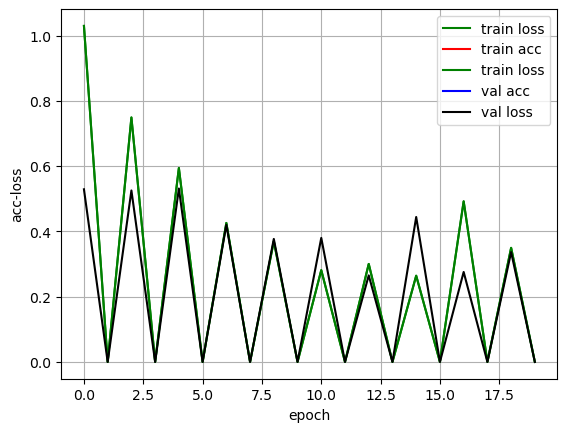

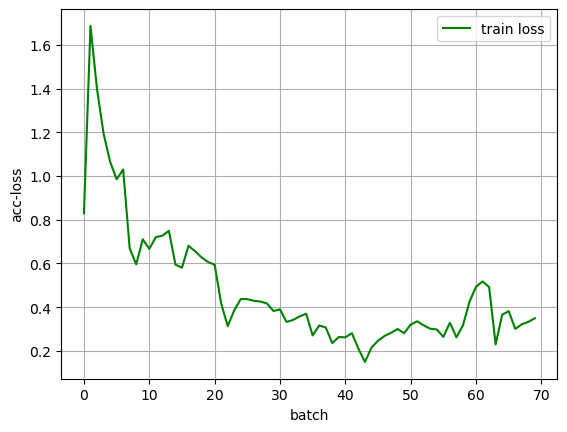

In [86]:
#default only 50, tf36cnn 99
xception(num_class=2,epochs=20)
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

# Model 3: VGG16

In [83]:
def vgg16( num_class, epochs,savepath='./VGG16.h5.keras',history=history_this,input_shape=INPUT_SIZE):
    #It first loads the VGG16 model with pre-trained weights from ImageNet and without the top (final fully connected) layers
    model_fine_tune = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:15]:	#the number of frozen layers for transfer learning, have tuned from 5-18
        layer.trainable = False
    for layer in model_fine_tune.layers[15:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output) #GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='vgg')
    opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])	#set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_acc', patience=2, verbose=1, mode='max')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_acc',
        verbose=1,
        save_best_only=True,
        mode='max')
    hist = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        #workers=2,
        callbacks=[earlyStopping, saveBestModel, history],
    )

7/7 ━━━━━━━━━━━━━━━━━━━━ 175s 24s/step - accuracy: 0.8949 - loss: 0.2976 - val_accuracy: 0.8810 - val_loss: 0.4440
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 17/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 165s 23s/step - accuracy: 0.8434 - loss: 0.4160 - val_accuracy: 0.9286 - val_loss: 0.2756
Epoch 18/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 19/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 176s 24s/step - accuracy: 0.8651 - loss: 0.3289 - val_accuracy: 0.8452 - val_loss: 0.3365
Epoch 20/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


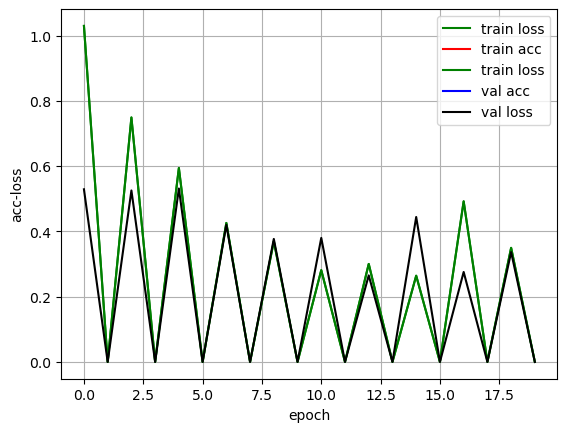

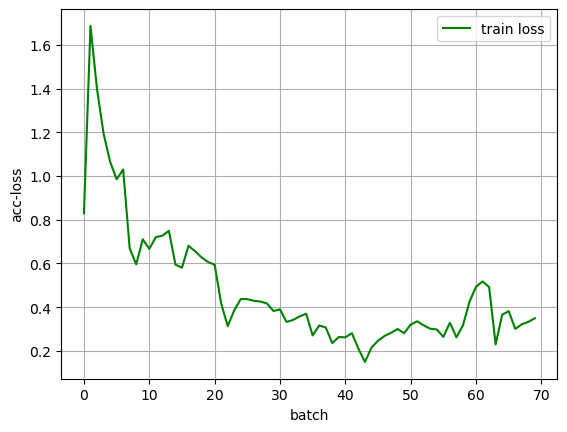

In [84]:
vgg16(num_class=2,epochs=20)	#tf36cnn
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()


# Model 4: VGG19

In [93]:
def vgg19( num_class, epochs,savepath='./VGG19.h5.keras',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:19]:	#the number of frozen layers for transfer learning, have tuned from 5-18
        layer.trainable = False
    for layer in model_fine_tune.layers[19:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='vgg')
    opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])	#set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_acc', patience=2, verbose=1, mode='min')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_acc',
        verbose=1,
        save_best_only=True,
        mode='min')
    hist = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        #workers=2,
        callbacks=[earlyStopping, saveBestModel, history],
    )

7/7 ━━━━━━━━━━━━━━━━━━━━ 320s 48s/step - accuracy: 0.8532 - loss: 0.3451 - val_accuracy: 0.9286 - val_loss: 0.2655
Epoch 18/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 19/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 214s 30s/step - accuracy: 0.8964 - loss: 0.2836 - val_accuracy: 0.9167 - val_loss: 0.2678
Epoch 20/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


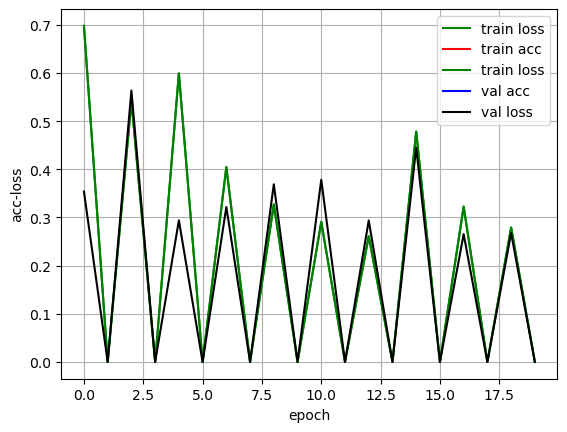

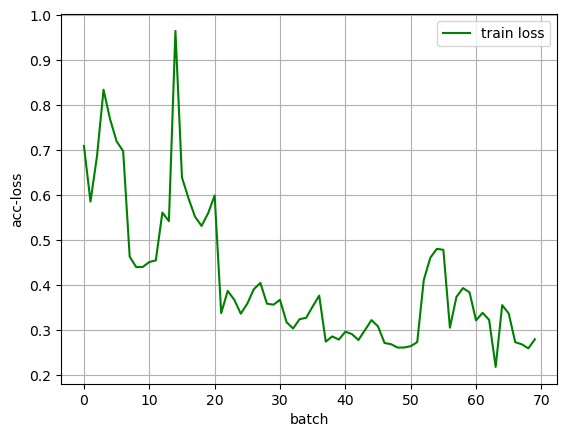

In [94]:
vgg19(num_class=2,epochs=20)	#binary classificaiton
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

# Model 5: ResNet

In [109]:
def resnet( num_class, epochs,savepath='./resnet.h5.keras',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:120]:	#the number of frozen layers for transfer learning, have tuned from 50-150
        layer.trainable = False
    for layer in model_fine_tune.layers[120:]:	#the number of trainable layers for transfer learning
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='resnet')
    opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) #set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_acc', patience=2, verbose=1, mode='max')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_acc',
        verbose=1,
        save_best_only=True,
        mode='max')
    hist = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[earlyStopping, saveBestModel, history],
    )

7/7 ━━━━━━━━━━━━━━━━━━━━ 92s 12s/step - accuracy: 0.7505 - loss: 0.4710 - val_accuracy: 0.3929 - val_loss: 538.2524
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 17/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 85s 12s/step - accuracy: 0.7365 - loss: 0.5302 - val_accuracy: 0.3929 - val_loss: 193.2000
Epoch 18/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 19/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 84s 11s/step - accuracy: 0.7540 - loss: 0.6224 - val_accuracy: 0.3929 - val_loss: 73.0245
Epoch 20/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


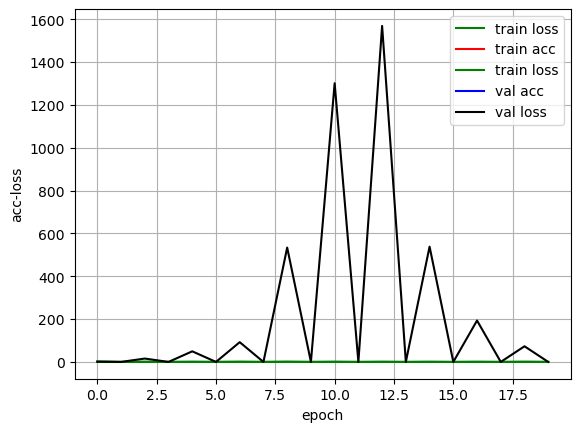

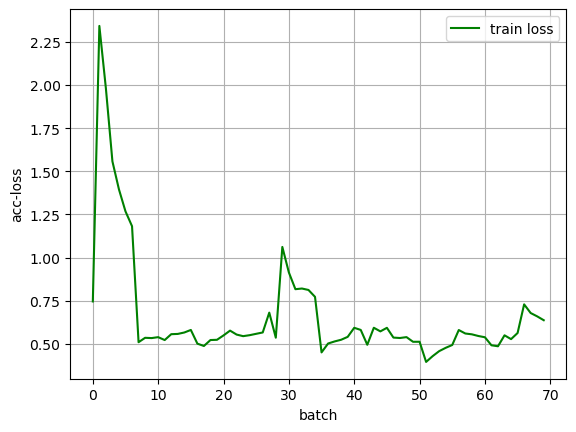

In [111]:
resnet(num_class=2,epochs=20)	#binary classificaiton
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

# Hyperparameter Optimization
Use VGG16 as an example.

Tuned hyperparameters of CNN:

1. The number of frozen layers
2. The number of epochs
3. Early stop patience
4. Learning rate
5. Dropout rate
Hyperparameter optimization methods:

1. Random search
2. Bayesian optimization - Tree Parzen Estimator(BO-TPE)

In [95]:
def vgg16( num_class,epochs=20,frozen=15,learning_rate=0.001,patience=2, dropout_rate=0.5,verbose=0, savepath='./VGG16.h5.keras',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:frozen]:	#the number of frozen layers for transfer learning, have tuned from 5-18
        layer.trainable = False
    for layer in model_fine_tune.layers[frozen:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(dropout_rate)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='vgg')
    opt = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])	#set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_acc', patience=patience, verbose=verbose, mode='max')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_acc',
        verbose=verbose,
        save_best_only=True,
        mode='max')
    hist = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        #workers=2,
        callbacks=[earlyStopping, saveBestModel, history],
        verbose = verbose
    )
    return hist

In [96]:
test_path = os.path.join(root_folder, 'test')
test_ratio = 0.1   # 10% for testing
for class_folder in os.listdir(root_folder):
        for file in files[train_count+val_count:]:
            src = os.path.join(class_path, file)
        if os.path.isfile(src):  # Check if the file exists
                dst = os.path.join(test_path, class_folder, file)
                os.makedirs(os.path.dirname(dst), exist_ok=True)  # Create destination directory if it doesn't exist
                shutil.copy(src, dst)

In [97]:
def prediction(vgg_model):
#read images from validation folder
    rootdir = test_path
    test_laels = []
    test_images=[]
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if not (file.endswith(".jpeg"))|(file.endswith(".jpg"))|(file.endswith(".png")):
                continue
            test_laels.append(subdir.split('/')[-1])
            test_images.append(os.path.join(subdir, file))

    predict=[]
    length=len(test_images)
    label=validation_generator.class_indices
    label={v: k for k, v in label.items()}
    for i in range(length):
        inputimg=test_images[i]
        test_batch=[]
        thisimg=np.array(Image.open(inputimg))/255 #read all the images in validation set
        #print(thisimg)
        test_shape=(1,)+thisimg.shape
        thisimg=thisimg.reshape(test_shape)
        vgg_model_batch=vgg_model.predict(thisimg) #use master model to process the input image
        #generate result by model 1
        prob=vgg_model_batch[0,np.argmax(vgg_model_batch,axis=1)[0]]
        res=label[np.argmax(vgg_model_batch,axis=1)[0]]
        predict.append(res)
    acc=accuracy_score(test_laels,predict)
    return acc

In [99]:
%pip install hyperopt

   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.6 MB 393.8 kB/s eta 0:00:04
   --- ------------------------------------ 0.1/1.6 MB 901.1 kB/s eta 0:00:02
   ------- -------------------------------- 0.3/1.6 MB 1.6 MB/s eta 0:00:01
   ---------------- ----------------------- 0.7/1.6 MB 3.0 MB/s eta 0:00:01
   ---------------------------- ----------- 1.1/1.6 MB 4.4 MB/s eta 0:00:01
   ------------------------------------ --- 1.4/1.6 MB 4.8 MB/s eta 0:00:01
   ---------------------------------------- 1.6/1.6 MB 4.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/200.5 kB ? eta -:--:--
   --------------------------------------- 200.5/200.5 kB 12.7 MB/s eta 0:00:00


In [106]:
#define the objective function to be optimized
import time
from hyperopt import hp, fmin, tpe, rand, STATUS_OK, Trials
import matplotlib.pyplot as plt
import statistics 

def objective(params):
    
    params = {
        'frozen': int(params['frozen']),
        'epochs': int(params['epochs']),
        'patience': int(params['patience']),
        'lr': abs(float(params['lr'])),
        'dropout_rate': abs(float(params['dropout_rate'])),
    }
    frozen=params['frozen']
    epochs=params['epochs']
    patience=params['patience']
    learning_rate=params['lr']
    dropout_rate=params['dropout_rate']

    vgg16(num_class=2, frozen=frozen,epochs=epochs,patience=patience, learning_rate=learning_rate, dropout_rate=dropout_rate)

    acc=prediction(vgg_model=load_model('./VGG16.h5.keras'))

    print('accuracy:%s'%acc)
    return {'loss': -acc, 'status': STATUS_OK }
    

In [108]:
#Hyperparameter optimization by Bayesian optimization - Tree Parzen Estimator
space = {
    'frozen': hp.quniform('frozen', 15, 18, 1),
    'epochs': hp.quniform('epochs', 5, 21, 5),
    'patience': hp.quniform('patience', 2, 4, 1),
    'lr': hp.quniform('lr', 0.001, 0.006, 0.001),
    'dropout_rate': hp.quniform('dropout_rate', 0.3, 0.6, 0.1),
}

t1=time.time()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)
print("Hyperopt estimated optimum {}".format(best))
t2=time.time()
print("Time: "+str(t2-t1))

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

  0%|          | 0/10 [14:13<?, ?trial/s, best loss=?]


KeyboardInterrupt: 